In [20]:
import tensorflow as tf

def euclidean_dist(x, z):
  n2 = tf.shape(z)[0]
  x_ = tf.expand_dims(x,len(x.shape))
  # x_ = tf.tile(x_, [1,1, n2]) #optional, will be broadcasted
  z_ = tf.expand_dims(tf.transpose(z),0)
  res = tf.square(x_- z_)
  res = tf.reduce_sum(res, 1)
  return res

import numpy as np
def split_data():
  np.random.seed(521)
  Data = np.linspace(1.0, 10.0, num=100)[:, np.newaxis]
  Target = np.sin(Data) + 0.1*np.power(Data,2) + 0.5*np.random.randn(100,1)
  randIdx = np.arange(100)
  np.random.shuffle(randIdx)
  trainData, trainTarget = Data[randIdx[:80]], Target[randIdx[:80]]
  validData, validTarget = Data[randIdx[80:90]], Target[randIdx[80:90]]
  testData, testTarget = Data[randIdx[90:100]], Target[randIdx[90:100]]
  return trainData, trainTarget, validData, validTarget, testData, testTarget

def data_segmentation(data_path, target_path, task):
  # task = 0 >> select the name ID targets for face recognition task
  # task = 1 >> select the gender ID targets for gender recognition task
  data = np.load(data_path)/255
  data = np.reshape(data, [-1, 32*32])
  target = np.load(target_path)
  np.random.seed(45689)
  rnd_idx = np.arange(np.shape(data)[0])
  np.random.shuffle(rnd_idx)
  trBatch = int(0.8*len(rnd_idx))
  validBatch = int(0.1*len(rnd_idx))
  trainData, validData, testData = data[rnd_idx[1:trBatch],:], \
  data[rnd_idx[trBatch+1:trBatch + validBatch],:],\
  data[rnd_idx[trBatch + validBatch+1:-1],:]
  trainTarget, validTarget, testTarget = target[rnd_idx[1:trBatch], task], \
  target[rnd_idx[trBatch+1:trBatch + validBatch], task],\
  target[rnd_idx[trBatch + validBatch + 1:-1], task]
  return trainData, validData, testData, trainTarget, validTarget, testTarget

def getMSETensor(predictions, label):
    N = tf.cast(tf.shape(label)[0],tf.float32)
    mse = 1/(2*N) * tf.reduce_sum(tf.square((predictions-label)))
    return mse

class KNNBuilder:
  def __init__(self, k):
    self.k = k
  def setData(self, trainData, trainTarget, validData, validTarget, testData, testTarget):
    self.trainData = trainData
    self.trainTarget = trainTarget
    self.validData = validData
    self.validTarget = validTarget
    self.testData = testData
    self.testTarget = testTarget
  def build(self):
    tf.reset_default_graph()
    trainData = tf.placeholder(tf.float32, shape=(None, 1), name="trainData")
    trainTarget = tf.placeholder(tf.float32, shape=(None, 1), name="trainTarget")
    
    X = tf.placeholder(tf.float32, shape=(None,1), name="X")
    distances = -euclidean_dist(X,trainData)
    k_neighbors, k_indices = tf.nn.top_k(distances, k=self.k, name="k_neighbors") # size is n*k

    k_indices = tf.expand_dims(k_indices, 2)
    predictions = tf.gather_nd(trainTarget,k_indices)
    predictions = tf.reduce_mean(predictions, 1)
    
    X_labels = tf.placeholder(tf.float32, shape=(None,1), name="label")
    mse = getMSETensor(predictions, X_labels)
    
    return predictions, mse


In [32]:
trainData1, trainTarget1, validData1, validTarget1, testData1, testTarget1 = split_data() 
data1 = [trainData1, trainTarget1, validData1, validTarget1, testData1, testTarget1]

In [33]:
feed_dict_valid={'X:0':validData1, 'label:0': validTarget1, 'trainData:0':trainData1, 'trainTarget:0':trainTarget1}
feed_dict_test={'X:0':testData1, 'label:0': testTarget1, 'trainData:0':trainData1, 'trainTarget:0':trainTarget1}
feed_dict_train={'X:0':trainData1, 'label:0': trainTarget1, 'trainData:0':trainData1, 'trainTarget:0':trainTarget1}
for i in (1,3,5,50):
    print("At k = {}:".format(i))
    pred,loss = KNNBuilder(i).build()
    sess = tf.Session()
    for case, feed in [('training', feed_dict_train), ('validation', feed_dict_valid), ('testing', feed_dict_test)]:
        pred_,loss_=sess.run((pred,loss),feed_dict=feed);
        print("    {} loss: {}".format(case, loss_))

At k = 1:
    training loss: 0.0
    validation loss: 0.27154967188835144
    testing loss: 0.31100401282310486
At k = 3:
    training loss: 0.10524209588766098
    validation loss: 0.32627829909324646
    testing loss: 0.1450919657945633
At k = 5:
    training loss: 0.11854124069213867
    validation loss: 0.3104385435581207
    testing loss: 0.1783265769481659
At k = 50:
    training loss: 1.2480087280273438
    validation loss: 1.2287017107009888
    testing loss: 0.7069347500801086


At k = 1:
At k = 3:
At k = 5:
At k = 50:


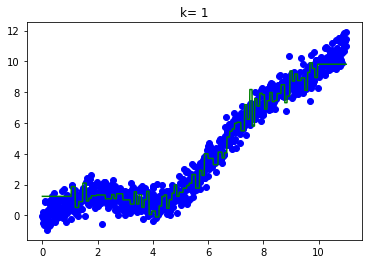

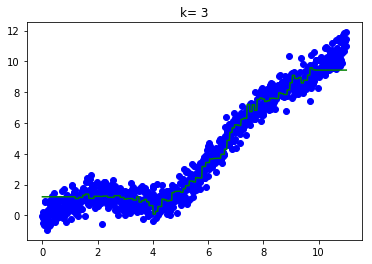

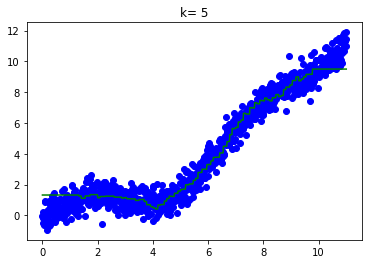

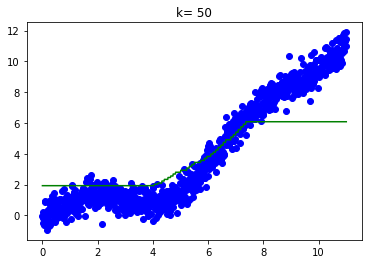

In [54]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

X = np.linspace(0.0, 11.0, num=1000)[:, np.newaxis]
Target = np.sin( X ) + 0.1 * np.power( X , 2) \
         + 0.5 * np.random.randn(1000 , 1)

for i in (1,3,5,50):
    print("At k = {}:".format(i))
    pred,loss = KNNBuilder(i).build()
    sess = tf.Session()
    feed_dict ={'X:0':X, 'label:0': Target, 'trainData:0':trainData1, 'trainTarget:0':trainTarget1}
    pred_,loss_=sess.run((pred,loss),feed_dict=feed_dict);
    plt.figure()
    plt.scatter(X,Target,c='b')
    plt.plot(X,pred_,"g")
    plt.title("k= "+ str(i))
    

In [2]:
trainData, validData, testData, trainTarget, validTarget, testTarget = data_segmentation('data.npy', 'target.npy', 1)
data = [trainData, trainTarget, validData, validTarget, testData, testTarget]

In [3]:
trainData

array([[ 0.78431373,  0.77254902,  0.52156863, ...,  0.29803922,
         0.10196078,  0.08627451],
       [ 0.16078431,  0.1372549 ,  0.15294118, ...,  0.2745098 ,
         0.30980392,  0.34509804],
       [ 0.29803922,  0.32156863,  0.27058824, ...,  0.04705882,
         0.07058824,  0.05098039],
       ..., 
       [ 0.79607843,  0.4745098 ,  0.37254902, ...,  0.10980392,
         0.10980392,  0.13333333],
       [ 0.13333333,  0.10588235,  0.30980392, ...,  0.55686275,
         0.83137255,  0.95686275],
       [ 0.15294118,  0.14117647,  0.22352941, ...,  0.93333333,
         0.85882353,  0.69411765]])

In [4]:
trainTarget

array([1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1,
       1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 1,

In [19]:
class KNN_classifer_builder:
  def __init__(self, k):
    self.k = k
  def setData(self, trainData, trainTarget, validData, validTarget, testData, testTarget):
    self.trainData = trainData
    self.trainTarget = trainTarget
    self.validData = validData
    self.validTarget = validTarget
    self.testData = testData
    self.testTarget = testTarget
  def build(self):
    tf.reset_default_graph()
    trainData = tf.placeholder(tf.float32, shape=(None, 1024), name="trainData") #n2*1
    trainTarget = tf.placeholder(tf.int32, shape=(None, 1), name="trainTarget")
    X = tf.placeholder(tf.float32, shape=(None, 1024), name="X")
    
    distances = -euclidean_dist(X,trainData) #n1*n2
    k_neighbors, k_indices = tf.nn.top_k(distances, k=self.k, name="k_neighbors") # size is n1*k, choose k indice from n2

    k_indices = tf.expand_dims(k_indices, 2) #traintarget is 2d, so the indice should be 2d, expand k so that each indice is 2d
    predictions = tf.gather_nd(trainTarget,k_indices)
    predictions = tf.squeeze(predictions, 2)
    #n1 = tf.shape(predictions,out_type=tf.int32)[0]
    #i = tf.constant(0,dtype=tf.int32)
    #cond = lambda i: tf.less(i, 10)
    #tmp_res = tf.Variable(tf.constant(0,shape=[92,1]))
    #body = lambda i: tf.add(i, 1)
    #def cond(i,n1,tmp_res):
     #   return tf.less(i,n1)
    #def body(i,n1,tmp_res):
     #   uniques,idxs,counts = tf.unique_with_counts(predictions[i])
      #  #tmp_res.append(tf.cast(uniques[tf.cast(tf.argmax(counts),tf.int32)], tf.int32))
       # tmp_res[i] = tf.cast(uniques[tf.cast(tf.argmax(counts),tf.int32)], tf.int32)
        #return tf.add(i,1), n1, tmp_res
    #loop_res=tf.while_loop(cond,body,[i,n1,tmp_res])
    self.all_predictions = predictions
    return predictions
    #tf.unique_with_counts(predictions)
  def run(self, sess):
    feed_dict={tf.get_default_graph().get_tensor_by_name('trainData:0'):self.trainData, \
                        tf.get_default_graph().get_tensor_by_name('trainTarget:0'):self.trainTarget[:,np.newaxis], \
                        tf.get_default_graph().get_tensor_by_name('X:0'):self.validData}

    res = []
    for i in range(self.validData.shape[0]):
        get_counts_i = tf.unique_with_counts(self.all_predictions[i])
        uniques, indices, counts = get_counts_i
        max_i = tf.cast(tf.argmax(counts),tf.int32)
        tmp = uniques[max_i]
        res.append(tmp)
    return sess.run(res, feed_dict=feed_dict)


In [20]:
knn_c = KNN_classifer_builder(5)
knn_c.build()
knn_c.setData(*data)

In [21]:
sess2 = tf.Session()
#print(sess2.run(knn_c, feed_dict={'trainData:0':trainData, 'trainTarget:0':trainTarget[:,np.newaxis], 'X:0':validData}))
print(knn_c.run(sess2))

[1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0]


In [8]:
validTarget

array([1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0], dtype=uint8)

In [9]:
get_counts_i = tf.unique_with_counts([1,2,3, 1])
uniques, indices, counts = sess2.run(get_counts_i)
print (uniques, indices, counts)

[1 2 3] [0 1 2 0] [2 1 1]
